# boostcourse ai224 / 베이스라인 모델 3 하이퍼 파라미터 튜닝

- 세번째 베이스라인 모델에서 LightGBM에 Optuna를 이용해서 하이퍼 파라미터 튜닝 적용

## Function 정의

- seed_everything() : seed 고정 함수
- generate_label() : label 생성 함수
- print_score() : 평가지표 출력 함수
- feature_preprocessing() : 데이터 전처리 함수(label encoding, 결측치 처리)
- feature_engineering1() : 피처 엔지니어링 함수
- make_lgb_oof_prediction() : LightGBM cross validation out of fold train/predict 함수
- plot_feature_importances() : 피처 중요도 플롯 함수
- objective() : optuna objective 함수

## Library Import

In [1]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random
from typing import List

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
import optuna

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

## Fix Seed 함수 정의

In [2]:
'''
    결과의 재현성을 위해 seed 값을 설정하는 함수
'''
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

## 레이블 생성 함수 정의

- 레이블 생성 함수는 연월을 인자로 받아서 고객 아이디별로 총 구매액이 인자로 받는 구매액 임계값을 넘는지 여부를 바이너리 레이블로 생성하는 함수

In [3]:
TOTAL_THRES = 300

'''
    입력인자로 받는 year_month에 대해 고객 ID별로 총 구매액이
    구매액 임계값을 넘는지 여부의 binary label을 생성하는 함수
'''
def generate_label(df, year_month, total_thres=TOTAL_THRES, print_log=False):
    df = df.copy()
    
    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month']<year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month']==year_month]
    
    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = year_month
    
    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    
    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')
    
    return label

## 평가지표 출력 함수 정의

In [4]:
'''
    평가지표를 출력하는 함수
'''
def print_score(label: List[float], pred: List[float], prob_thres: float = 0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

## 데이터 전처리 함수 정의
- 범주형 변수 레이블 인코딩
- 결측치 중위값으로 채움

In [5]:
'''
    입력인자로 받는 train, test 데이터에 대해 범주형 피쳐는 레이블 인코딩을 
    진행하고 결측치에 대해서는 중위값으로 데이터 전처리를 하는 함수
'''
def feature_preprocessing(
    train: pd.DataFrame, 
    test: pd.DataFrame, 
    features: list, 
    do_imputing=True
):
    x_tr = train.copy()
    x_te = test.copy()
    
    # 범주형 피처 이름을 저장할 변수
    cate_cols = []

    # 레이블 인코딩
    for f in features:
        if x_tr[f].dtype.name == 'object': # 데이터 타입이 object(str)이면 레이블 인코딩
            cate_cols.append(f)
            le = LabelEncoder()
            # train + test 데이터를 합쳐서 레이블 인코딩 함수에 fit
            le.fit(list(x_tr[f].values) + list(x_te[f].values))
            
            # train 데이터 레이블 인코딩 변환 수행
            x_tr[f] = le.transform(list(x_tr[f].values))
            
            # test 데이터 레이블 인코딩 변환 수행
            x_te[f] = le.transform(list(x_te[f].values))

    print('categorical feature:', cate_cols)

    if do_imputing:
        # 중위값으로 결측치 채우기
        imputer = SimpleImputer(strategy='median')

        x_tr[features] = imputer.fit_transform(x_tr[features])
        x_te[features] = imputer.transform(x_te[features])
    
    return x_tr, x_te

## 피처 엔지니어링 함수 정의
- Pandas groupby aggregation 함수를 사용한 피처 엔지니어링

In [6]:
'''
    입력인자로 받는 year_month와 변수 prev_ym 기준으로 train, test 데이터를 생성 하고
    집계(aggregation) 함수를 사용하여 피처 엔지니어링을 하는 함수
'''
def feature_engineering1(df: pd.DataFrame, year_month: str):
    df = df.copy()
    
    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')
    
    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]
    
    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]
    
    # group by aggregation 함수 선언
    agg_func = ['mean','max','min','sum','count','std','skew']
    all_train_data = pd.DataFrame()
    
    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train.loc[train['order_date'] < tr_ym].groupby(['customer_id']).agg(agg_func)

        # 멀티 레벨 컬럼을 사용하기 쉽게 1 레벨 컬럼명으로 변경
        new_cols = []
        for col in train_agg.columns.levels[0]:
            for stat in train_agg.columns.levels[1]:
                new_cols.append(f'{col}-{stat}')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        train_agg['year_month'] = tr_ym
        
        all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test_agg = test.groupby(['customer_id']).agg(agg_func)
    test_agg.columns = new_cols
    
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')

    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)
    
    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)
    
    return x_tr, x_te, all_train_data['label'], features

## LightGBM cross validation out of fold train/predict 함수 정의

In [7]:
'''
    학습 데이터(x_tr), 검증 데이터(x_val), 테스트 데이터(test)로 LightGBM 모델을
    학습, 교차(cross) 검증 및 테스트하고 사용된 피처들의 중요도를 반환하는 함수
'''

def make_lgb_oof_prediction(train, y, test, features, categorical_features='auto', model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)
        
        # LightGBM 모델 훈련
        clf = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature=categorical_features,
            verbose_eval=200
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_val)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(x_test) / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

## 피처 중요도 플롯 함수 정의

In [8]:
'''
    피처 중요도 정규화(importance_normalized) 및 누적 중요도(cumulative_importance)를 계산하고
    중요도 정규화 순으로 n개의 바플롯을 그리는 함수
'''
def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized', 
                            x='feature', color=color, 
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()
    
    return df

## Train 데이터 읽기
- 9개의 feature를 가진 780502개의 train data

In [9]:
data = pd.read_csv("../input/train.csv", parse_dates=["order_date"])
print(data.shape)  # data shape 확인
data.head()

(780502, 9)


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


## Pandas info() 함수로 데이터 타입 및 null 체크

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780502 non-null  object        
 1   product_id   780502 non-null  object        
 2   description  780502 non-null  object        
 3   quantity     780502 non-null  int64         
 4   order_date   780502 non-null  datetime64[ns]
 5   price        780502 non-null  float64       
 6   customer_id  780502 non-null  int64         
 7   country      780502 non-null  object        
 8   total        780502 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 53.6+ MB


## Pandas isna(), sum() 함수로 null 데이터 개수 체크

In [11]:
data.isna().sum()

order_id       0
product_id     0
description    0
quantity       0
order_date     0
price          0
customer_id    0
country        0
total          0
dtype: int64

## Pandas describe() 함수에 include='all' 인자 설정으로 수치형, 범주형 데이터 기본 통계량 확인

In [12]:
data.describe(include='all')

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
count,780502,780502,780502,780502.000000,780502,780502.000000,780502.000000,780502,780502.000000
unique,43955,4645,5297,NaN,40615,NaN,NaN,41,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,NaN,United Kingdom,NaN
freq,542,5096,5096,NaN,543,NaN,NaN,700317,NaN
first,NaN,NaN,NaN,NaN,2009-12-01 07:45:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-11-30 17:42:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.623307,NaN,6.140931,15313.393466,NaN,33.715373
std,NaN,NaN,NaN,143.906302,NaN,119.042266,1695.765797,NaN,274.207403
min,NaN,NaN,NaN,-74215.000000,NaN,0.000000,12346.000000,NaN,-127352.940000
25%,NaN,NaN,NaN,2.000000,NaN,2.062500,13963.000000,NaN,7.260000


## 2011년 11월 Label 데이터 생성

In [13]:
label_2011_11 = generate_label(data, '2011-11')['label']

## Label 데이터 분포 플롯

0    4534
1    1188
Name: label, dtype: int64

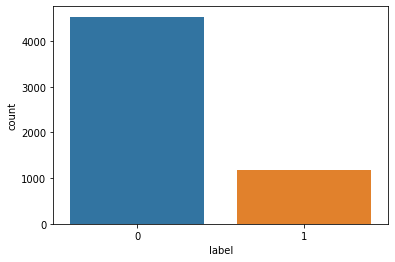

In [14]:
sns.countplot(label_2011_11);
label_2011_11.value_counts()

## LightGBM Hyperparameter 선언
- early stopping 기능을 사용하기 위해 n_estimators, early_stopping_rounds 설정

In [15]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.8, # 피처 샘플링 비율
    'bagging_fraction': 0.8, # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 10000, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': SEED,
    'verbose': -1,
    'n_jobs': -1,    
}

## 2011년 12월 LightGBM 베이스라인 모델 예측
- Validation 성능 측정

In [16]:
train, test, y, features = feature_engineering1(data, '2011-12')
y_oof, test_preds, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)

categorical feature: []
x_tr.shape (5722, 24) , x_te.shape (5914, 24)
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	training's auc: 0.902047	valid_1's auc: 0.76602
Fold 1 | AUC: 0.7660200644134305
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	training's auc: 0.926121	valid_1's auc: 0.790915
Fold 2 | AUC: 0.790915485136786
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	training's auc: 0.852035	valid_1's auc: 0.794034
Fold 3 | AUC: 0.7940341969685657
--------------------------------------------------

In [17]:
print_score(label_2011_11, y_oof)

Precision: 0.65435
Recall: 0.20875
F1 Score: 0.31653
ROC AUC Score: 0.76724


## 2011년 12월 LightGBM 베이스라인 모델 예측 데이터 분포

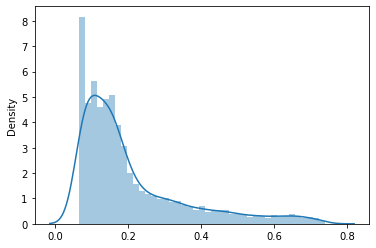

In [18]:
sns.distplot(test_preds)
plt.show()

## LightGBM 피처 중요도 플롯

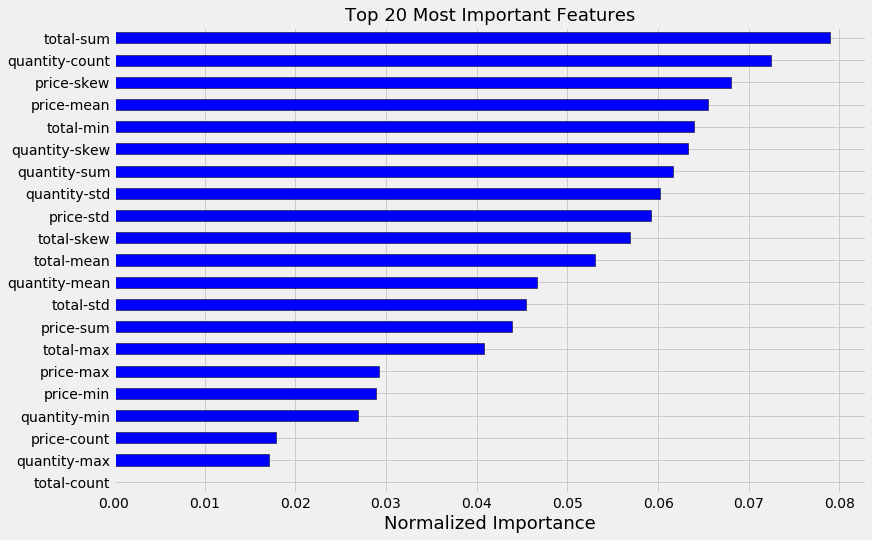

In [19]:
fi = plot_feature_importances(fi)

## Optuna Objective Function 정의

In [20]:
'''
    하이퍼파라미터 탐색 범위를 정의하고 튜닝 및 검증을 진행하는 함수
'''

def objective(trial, label=label_2011_11):
    lgb_params = {
        'objective': 'binary', # 이진 분류
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256), # num_leaves 값을 2-256까지 정수값 중에 사용
        'max_bin': trial.suggest_int('max_bin', 128, 256), # max_bin 값을 128-256까지 정수값 중에 사용
        # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),
        # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        # 데이터 샘플링 횟수를 1-7까지 정수값 중에 사용
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'n_estimators': 10000, # 트리 개수
        'early_stopping_rounds': 100,
        # L1 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        # L2 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'seed': SEED,
        'verbose': -1,
        'n_jobs': -1,    
    }
    
    # oof prediction 함수 호출해서 out of fold validation 예측값을 얻어옴
    y_oof, test_preds, fi = make_lgb_oof_prediction(train, y, test, features, model_params=lgb_params)
    
    # Validation 스코어 계산
    val_auc = roc_auc_score(label, y_oof)
    
    return val_auc

## Optuna study 생성, auc이기 때문에 최대화 하는 방향으로 하이퍼 파라미터 탐색

In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10) # 10회 동안 하이퍼 파라미터 탐색

[I 2022-06-02 23:15:09,973] A new study created in memory with name: no-name-842d22c0-4ab4-4173-b081-682b5152ec94


fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.358769	valid_1's binary_logloss: 0.440838
Fold 1 | AUC: 0.7475382223373932
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.309118	valid_1's binary_logloss: 0.409588
Fold 2 | AUC: 0.7940436086328805
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.29777	valid_1's binary_logloss: 0.414426
Fold 3 | AUC: 0.7844022997088032
-----------------------------------------------------

[I 2022-06-02 23:15:12,914] Trial 0 finished with value: 0.7730202332099112 and parameters: {'num_leaves': 123, 'max_bin': 131, 'min_data_in_leaf': 31, 'feature_fraction': 0.7190295717719191, 'bagging_fraction': 0.8791829118831508, 'bagging_freq': 6, 'lambda_l1': 0.00040485153901647047, 'lambda_l2': 1.6336163441394689}. Best is trial 0 with value: 0.7730202332099112.


Early stopping, best iteration is:
[16]	training's binary_logloss: 0.342602	valid_1's binary_logloss: 0.434956
Fold 10 | AUC: 0.7557645574786206
--------------------------------------------------------------------------------

Mean AUC = 0.772857145239492
OOF AUC = 0.7730202332099112
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.344625	valid_1's binary_logloss: 0.440558
Fold 1 | AUC: 0.749444711805427
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.313111	valid_1's binary_logloss: 0.416613
Fold 2 | AUC: 0.7814015474031022
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21

[I 2022-06-02 23:15:14,993] Trial 1 finished with value: 0.7661099489231382 and parameters: {'num_leaves': 46, 'max_bin': 163, 'min_data_in_leaf': 20, 'feature_fraction': 0.9248878492931469, 'bagging_fraction': 0.7062164308667198, 'bagging_freq': 2, 'lambda_l1': 2.0880434437255522e-06, 'lambda_l2': 5.271551297646962e-08}. Best is trial 0 with value: 0.7730202332099112.


fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.343313	valid_1's binary_logloss: 0.445543
Fold 1 | AUC: 0.7416891866878911
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.282362	valid_1's binary_logloss: 0.427063
Fold 2 | AUC: 0.7692962647614112
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.318948	valid_1's binary_logloss: 0.424897
Fold 3 | AUC: 0.7642238482789517
----------------------------------------------------

[I 2022-06-02 23:15:18,102] Trial 2 finished with value: 0.7596934088718384 and parameters: {'num_leaves': 253, 'max_bin': 143, 'min_data_in_leaf': 20, 'feature_fraction': 0.560117983887382, 'bagging_fraction': 0.6677323854656387, 'bagging_freq': 6, 'lambda_l1': 4.064943928773844e-06, 'lambda_l2': 0.00273183546909668}. Best is trial 0 with value: 0.7730202332099112.


Early stopping, best iteration is:
[13]	training's binary_logloss: 0.335888	valid_1's binary_logloss: 0.424198
Fold 10 | AUC: 0.7749642903519023
--------------------------------------------------------------------------------

Mean AUC = 0.759566916712357
OOF AUC = 0.7596934088718384
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.291416	valid_1's binary_logloss: 0.443526
Fold 1 | AUC: 0.7483989190389811
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.335078	valid_1's binary_logloss: 0.422609
Fold 2 | AUC: 0.7858808721726578
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 2

[I 2022-06-02 23:15:21,778] Trial 3 finished with value: 0.759627873351958 and parameters: {'num_leaves': 124, 'max_bin': 244, 'min_data_in_leaf': 17, 'feature_fraction': 0.7681679842596292, 'bagging_fraction': 0.680612267086513, 'bagging_freq': 7, 'lambda_l1': 0.0010040700803256232, 'lambda_l2': 1.008275653730267e-08}. Best is trial 0 with value: 0.7730202332099112.


Early stopping, best iteration is:
[16]	training's binary_logloss: 0.29318	valid_1's binary_logloss: 0.428187
Fold 10 | AUC: 0.766987589737882
--------------------------------------------------------------------------------

Mean AUC = 0.7619390984817592
OOF AUC = 0.759627873351958
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.365874	valid_1's binary_logloss: 0.427188
Fold 1 | AUC: 0.7704993891829859
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.364378	valid_1's binary_logloss: 0.410717
Fold 2 | AUC: 0.7935438492577648
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21)

[I 2022-06-02 23:15:23,785] Trial 4 finished with value: 0.7730596844789611 and parameters: {'num_leaves': 109, 'max_bin': 183, 'min_data_in_leaf': 36, 'feature_fraction': 0.977091075762885, 'bagging_fraction': 0.5289190994239255, 'bagging_freq': 7, 'lambda_l1': 1.5032332935228183, 'lambda_l2': 0.0562125143152242}. Best is trial 4 with value: 0.7730596844789611.


OOF AUC = 0.7730596844789611
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.29396	valid_1's binary_logloss: 0.437282
Fold 1 | AUC: 0.7599304038796134
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.318098	valid_1's binary_logloss: 0.420236
Fold 2 | AUC: 0.7738311183504238
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.320579	valid_1's binary_logloss: 0.417463
Fold 3 | AUC: 0.7774023743746733
------------------------

[I 2022-06-02 23:15:26,609] Trial 5 finished with value: 0.7685114637033472 and parameters: {'num_leaves': 138, 'max_bin': 187, 'min_data_in_leaf': 29, 'feature_fraction': 0.4319701572064888, 'bagging_fraction': 0.8117052197814262, 'bagging_freq': 7, 'lambda_l1': 0.4710381029937891, 'lambda_l2': 0.0020167537893002363}. Best is trial 4 with value: 0.7730596844789611.


Early stopping, best iteration is:
[20]	training's binary_logloss: 0.316241	valid_1's binary_logloss: 0.429206
Fold 10 | AUC: 0.7586955311926095
--------------------------------------------------------------------------------

Mean AUC = 0.7693384724746375
OOF AUC = 0.7685114637033472
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.377792	valid_1's binary_logloss: 0.439325
Fold 1 | AUC: 0.7519157442712768
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.357712	valid_1's binary_logloss: 0.409769
Fold 2 | AUC: 0.7942749787139526
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 

[I 2022-06-02 23:15:28,529] Trial 6 finished with value: 0.7691282030717407 and parameters: {'num_leaves': 38, 'max_bin': 157, 'min_data_in_leaf': 31, 'feature_fraction': 0.8909868689458252, 'bagging_fraction': 0.6040143822565874, 'bagging_freq': 5, 'lambda_l1': 0.20983658435035635, 'lambda_l2': 0.025157866953928805}. Best is trial 4 with value: 0.7730596844789611.


fold: 10, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.363337	valid_1's binary_logloss: 0.432005
Fold 10 | AUC: 0.7588810358580518
--------------------------------------------------------------------------------

Mean AUC = 0.7686971885908506
OOF AUC = 0.7691282030717407
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.354266	valid_1's binary_logloss: 0.437837
Fold 1 | AUC: 0.7560989153370599
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.352721	valid_1's binary_logloss: 0.415114
Fold 2 | AUC: 0.7787176

[I 2022-06-02 23:15:30,895] Trial 7 finished with value: 0.7721597314120473 and parameters: {'num_leaves': 147, 'max_bin': 201, 'min_data_in_leaf': 28, 'feature_fraction': 0.9827290813289262, 'bagging_fraction': 0.42507960270616385, 'bagging_freq': 2, 'lambda_l1': 2.4584471519712796e-06, 'lambda_l2': 8.762998037376012e-05}. Best is trial 4 with value: 0.7730596844789611.


Early stopping, best iteration is:
[16]	training's binary_logloss: 0.358888	valid_1's binary_logloss: 0.426762
Fold 10 | AUC: 0.7639082122915392
--------------------------------------------------------------------------------

Mean AUC = 0.7726245141754631
OOF AUC = 0.7721597314120473
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.387805	valid_1's binary_logloss: 0.429296
Fold 1 | AUC: 0.7623829267389777
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.395045	valid_1's binary_logloss: 0.410146
Fold 2 | AUC: 0.7904249805649133
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 

[I 2022-06-02 23:15:32,316] Trial 8 finished with value: 0.7798659102419578 and parameters: {'num_leaves': 9, 'max_bin': 200, 'min_data_in_leaf': 19, 'feature_fraction': 0.7167667278844082, 'bagging_fraction': 0.7873846917740549, 'bagging_freq': 1, 'lambda_l1': 0.00012067093205297321, 'lambda_l2': 4.022608232446789e-06}. Best is trial 8 with value: 0.7798659102419578.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.379765	valid_1's binary_logloss: 0.419166
Fold 10 | AUC: 0.7796019069879607
--------------------------------------------------------------------------------

Mean AUC = 0.7804710831385552
OOF AUC = 0.7798659102419578
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.363906	valid_1's binary_logloss: 0.435971
Fold 1 | AUC: 0.7530263206604229
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.344279	valid_1's binary_logloss: 0.412718
Fold 2 | AUC: 0.7847517861770258
-----------------------------------------------

[I 2022-06-02 23:15:34,336] Trial 9 finished with value: 0.7731646712678913 and parameters: {'num_leaves': 256, 'max_bin': 156, 'min_data_in_leaf': 39, 'feature_fraction': 0.4407945910091102, 'bagging_fraction': 0.48869439423780553, 'bagging_freq': 7, 'lambda_l1': 9.914291424566816e-08, 'lambda_l2': 0.0001010209578706996}. Best is trial 8 with value: 0.7798659102419578.


Early stopping, best iteration is:
[16]	training's binary_logloss: 0.378317	valid_1's binary_logloss: 0.43075
Fold 10 | AUC: 0.7599013115179847
--------------------------------------------------------------------------------

Mean AUC = 0.773494715411431
OOF AUC = 0.7731646712678913


## Validation 스코어가 가장 잘 나온 하이퍼 파라미터 출력

In [22]:
study.best_params

{'num_leaves': 9,
 'max_bin': 200,
 'min_data_in_leaf': 19,
 'feature_fraction': 0.7167667278844082,
 'bagging_fraction': 0.7873846917740549,
 'bagging_freq': 1,
 'lambda_l1': 0.00012067093205297321,
 'lambda_l2': 4.022608232446789e-06}

## 가장 성능이 잘 나온 Validation 스코어 출력

In [23]:
study.best_value

0.7798659102419578

## 하이퍼 파라미터 탐색 관련한 전체 데이터를 판다스 데이터 프레임으로 보기

In [24]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_max_bin,params_min_data_in_leaf,params_num_leaves,state
0,0,0.773020,2022-06-02 23:15:09.975243,2022-06-02 23:15:12.914157,0 days 00:00:02.938914,0.879183,6,0.719030,4.048515e-04,1.633616e+00,131,31,123,COMPLETE
1,1,0.766110,2022-06-02 23:15:12.915380,2022-06-02 23:15:14.992949,0 days 00:00:02.077569,0.706216,2,0.924888,2.088043e-06,5.271551e-08,163,20,46,COMPLETE
2,2,0.759693,2022-06-02 23:15:14.994113,2022-06-02 23:15:18.102000,0 days 00:00:03.107887,0.667732,6,0.560118,4.064944e-06,2.731835e-03,143,20,253,COMPLETE
3,3,0.759628,2022-06-02 23:15:18.103137,2022-06-02 23:15:21.777887,0 days 00:00:03.674750,0.680612,7,0.768168,1.004070e-03,1.008276e-08,244,17,124,COMPLETE
4,4,0.773060,2022-06-02 23:15:21.779073,2022-06-02 23:15:23.784924,0 days 00:00:02.005851,0.528919,7,0.977091,1.503233e+00,5.621251e-02,183,36,109,COMPLETE
5,5,0.768511,2022-06-02 23:15:23.786139,2022-06-02 23:15:26.608916,0 days 00:00:02.822777,0.811705,7,0.431970,4.710381e-01,2.016754e-03,187,29,138,COMPLETE
6,6,0.769128,2022-06-02 23:15:26.610140,2022-06-02 23:15:28.528580,0 days 00:00:01.918440,0.604014,5,0.890987,2.098366e-01,2.515787e-02,157,31,38,COMPLETE
7,7,0.772160,2022-06-02 23:15:28.529846,2022-06-02 23:15:30.895077,0 days 00:00:02.365231,0.425080,2,0.982729,2.458447e-06,8.762998e-05,201,28,147,COMPLETE
8,8,0.779866,2022-06-02 23:15:30.896753,2022-06-02 23:15:32.315667,0 days 00:00:01.418914,0.787385,1,0.716767,1.206709e-04,4.022608e-06,200,19,9,COMPLETE
9,9,0.773165,2022-06-02 23:15:32.316928,2022-06-02 23:15:34.336413,0 days 00:00:02.019485,0.488694,7,0.440795,9.914291e-08,1.010210e-04,156,39,256,COMPLETE


## 하이퍼 파라미터 중요도 Visualization

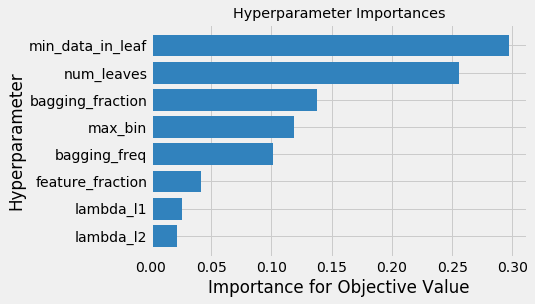

In [25]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

## 하이퍼 파라미터 탐색 히스토리 Visualization

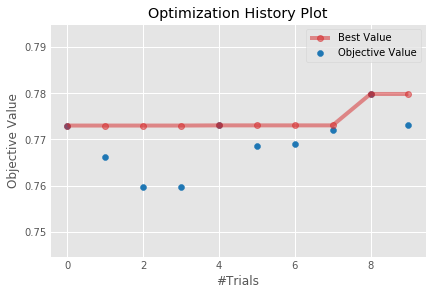

In [26]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

## 하이퍼 파라미터별 Validation 스코어의 관계 Visualization

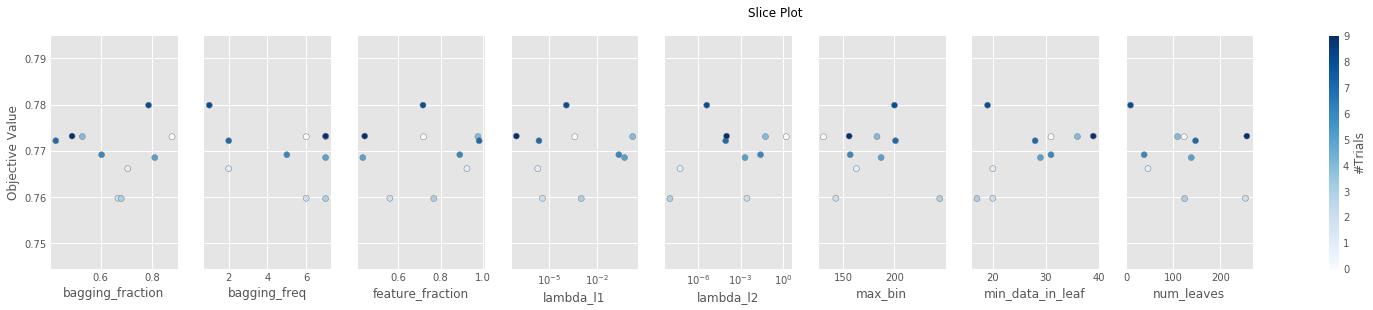

In [27]:
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

## 하이퍼 파라미터 Contour Visualization

[W 2022-06-02 23:15:36,063] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


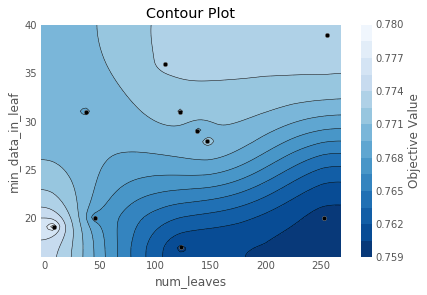

In [28]:
optuna.visualization.matplotlib.plot_contour(study, params=['num_leaves','min_data_in_leaf'])
plt.show()

## 하이퍼 파라미터 Parallel Coodinate Visualization

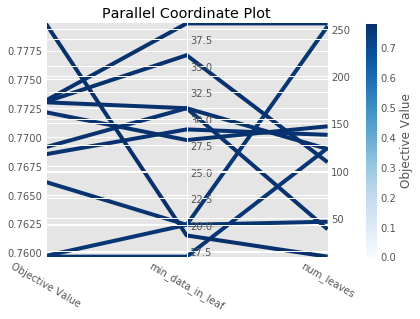

In [29]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['num_leaves','min_data_in_leaf'])
plt.show()